<a href="https://colab.research.google.com/gist/Shinjiray/afd61e9515b43e68e1ce8767104dfb18/cnnresnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### (The accuracy of this model came out to be 94.2%)

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import PIL
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, Dropout, Flatten
import matplotlib.pyplot as plt
import seaborn as sns

## Data preparataion and visualisation

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import os
import shutil

# Путь к директории, которую вы хотите очистить
directory_to_clear = '/content'

# Директории, которые вы хотите оставить
directories_to_keep = ['/content/.config', '/content/.ipynb_checkpoints', '/content/sample_data', '/content/drive']

# Проходимся по всем файлам и директориям внутри /content
for filename in os.listdir(directory_to_clear):
    file_path = os.path.join(directory_to_clear, filename)
    try:
        if file_path not in directories_to_keep:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
    except Exception as e:
        print(f"Не удалось удалить {file_path}: {e}")

print("Файлы и директории в /content были очищены, кроме указанных.")


Файлы и директории в /content были очищены, кроме указанных.


In [33]:
import os
import shutil
from sklearn.model_selection import train_test_split

#папкаобщ
dataset_dir = '/content/drive/MyDrive/Детали'
Dataclass = dataset_dir
#папкатрейн
train_dir = '/content/train_dir'
os.makedirs(train_dir, exist_ok=True)

#папка тест
test_dir = '/content/test_dir'
os.makedirs(test_dir, exist_ok=True)

#папкавал
val_dir = '/content/val_dir'
os.makedirs(val_dir, exist_ok=True)

In [34]:
# Получите список папок с названиями классов
class_names = os.listdir(dataset_dir)

# Переберите каждую папку класса и разделите данные на тренировочный, тестовый и валидационный наборы
for class_name in class_names:
    class_dir = os.path.join(dataset_dir, class_name)
    # список файлов в текущей папке класса
    file_list = os.listdir(class_dir)

    # Разделение данных
    train_files, test_val_files = train_test_split(file_list, test_size=0.3, random_state=42)
    test_files, val_files = train_test_split(test_val_files, test_size=0.5, random_state=42)
    #Распределение по папкам
    for file in train_files:
        src = os.path.join(class_dir, file)
        dst = os.path.join(train_dir, class_name, file)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

    for file in test_files:
        src = os.path.join(class_dir, file)
        dst = os.path.join(test_dir, class_name, file)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

    for file in val_files:
        src = os.path.join(class_dir, file)
        dst = os.path.join(val_dir, class_name, file)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)


In [35]:
img_height,img_width=224,224
batch_size=32

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  seed=123,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  val_dir,
  shuffle=False,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 535 files belonging to 19 classes.
Found 107 files belonging to 19 classes.


In [36]:
class_names = train_dataset.class_names
print(class_names)

['CS120.01.413', 'CS120.07.442', 'CS150.01.427-01', 'SU160.00.404', 'SU80.01.426', 'SU80.10.409A', 'ЗВТ86.103К-02', 'СВМ.37.060', 'СВМ.37.060А', 'СВП-120.00.060', 'СВП120.42.020', 'СВП120.42.030', 'СК20.01.01.01.406', 'СК20.01.01.02.402', 'СК30.01.01.02.402', 'СК30.01.01.03.403', 'СК50.01.01.404', 'СК50.02.01.411', 'СПО250.14.190']


In [37]:
len(class_names)

19

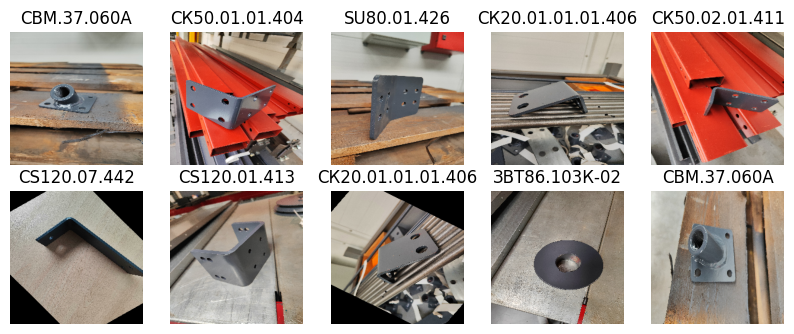

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(10):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Using Resnet50 as base model:

In [39]:
from tensorflow.keras.applications import ResNet50

In [40]:
model = Sequential()

base_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes=19,
                   weights='imagenet')


In [41]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

## Freezing the pre-trained layers so that we do not have to update weights ourselves:

In [42]:
for layer in base_model.layers:
        layer.trainable=False

## Building model:

In [43]:
from tensorflow.keras.optimizers import Adam

In [44]:
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5)) # to prevent overfitting
model.add(Dense(100, activation='softmax'))

In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 100)               51300     
                                                                 
Total params: 24688100 (94.18 MB)
Trainable params: 1100388 (4.20 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [46]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

## Training our model:

In [47]:
history = model.fit(train_dataset,
                    epochs=13,
                    validation_data=val_dataset,

                   )


Epoch 1/13
17/17 [==============================] - 62s 2s/step - loss: 4.5752 - accuracy: 0.0636 - val_loss: 3.0014 - val_accuracy: 0.2150
Epoch 2/13
17/17 [==============================] - 51s 2s/step - loss: 2.8273 - accuracy: 0.2318 - val_loss: 2.2166 - val_accuracy: 0.4019
Epoch 3/13
17/17 [==============================] - 47s 2s/step - loss: 2.2925 - accuracy: 0.3514 - val_loss: 1.8025 - val_accuracy: 0.5047
Epoch 4/13
17/17 [==============================] - 58s 2s/step - loss: 1.7828 - accuracy: 0.4710 - val_loss: 1.5199 - val_accuracy: 0.5888
Epoch 5/13
17/17 [==============================] - 54s 2s/step - loss: 1.5288 - accuracy: 0.5327 - val_loss: 1.3274 - val_accuracy: 0.6449
Epoch 6/13
17/17 [==============================] - 50s 2s/step - loss: 1.2821 - accuracy: 0.6262 - val_loss: 1.2102 - val_accuracy: 0.6729
Epoch 7/13
17/17 [==============================] - 48s 2s/step - loss: 1.0167 - accuracy: 0.6991 - val_loss: 1.1070 - val_accuracy: 0.7383
Epoch 8/13
17/17 [==

## Visualising learning curves for model loss and model accuracy:

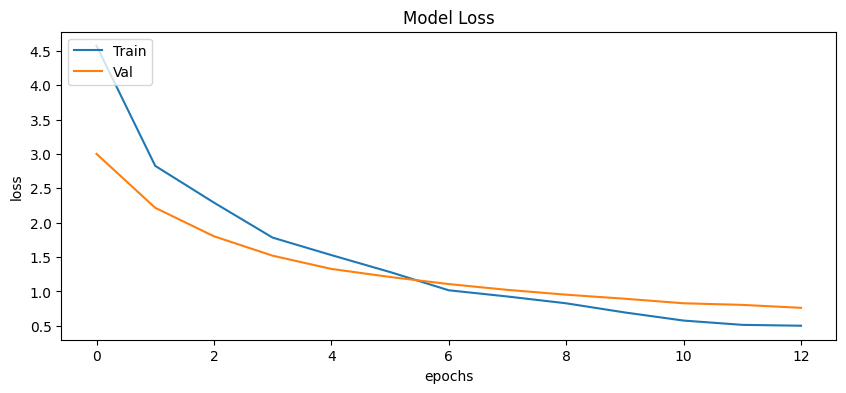

In [48]:
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['Train','Val'], loc= 'upper left')
plt.show()


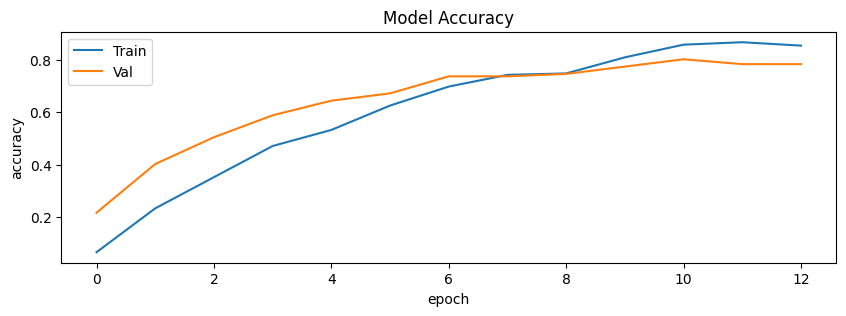

In [49]:
plt.figure(figsize=(10,3))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

## Test dataset prediction accuracy:

In [50]:

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed = 123,
    image_size=(img_height,img_width),
    shuffle=False
)

Found 98 files belonging to 19 classes.


In [51]:
print(test_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [52]:
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

In [68]:
img_path = '/content/test_dir/СВП120.42.030/IMG_20230920_143017.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [70]:
preds = model.predict(x)
print(class_names[np.argmax(preds)])
#print('Predicted:', decode_predictions( preds, top=19)[0])

1/1 [==============================] - 0s 25ms/step
СВП120.42.020


In [71]:
test_images, test_labels = tuple(zip(*test_dataset))

predictions = model.predict(test_dataset)
score = tf.nn.softmax(predictions)

4/4 [==============================] - 7s 1s/step


In [72]:
result = model.evaluate(test_dataset)
print("Test loss, test accuracy:", result)

4/4 [==============================] - 9s 2s/step - loss: 0.7712 - accuracy: 0.7755
Test loss, test accuracy: [0.7712465524673462, 0.7755101919174194]


## Classification report:

In [63]:
from sklearn.metrics import classification_report, confusion_matrix

In [64]:
y_test = np.concatenate(test_labels)
y_pred = np.array([np.argmax(s) for s in score])

print(classification_report(y_test, y_pred, target_names=class_names))

                   precision    recall  f1-score   support

     CS120.01.413       0.75      1.00      0.86         6
     CS120.07.442       0.83      0.83      0.83         6
  CS150.01.427-01       0.60      0.60      0.60         5
     SU160.00.404       0.71      1.00      0.83         5
      SU80.01.426       1.00      0.25      0.40         4
     SU80.10.409A       1.00      1.00      1.00         5
    ЗВТ86.103К-02       1.00      0.20      0.33         5
       СВМ.37.060       1.00      0.75      0.86         4
      СВМ.37.060А       0.86      1.00      0.92         6
   СВП-120.00.060       0.67      1.00      0.80         4
    СВП120.42.020       0.83      1.00      0.91         5
    СВП120.42.030       0.75      0.60      0.67         5
СК20.01.01.01.406       0.50      0.80      0.62         5
СК20.01.01.02.402       0.67      0.40      0.50         5
СК30.01.01.02.402       0.50      0.50      0.50         4
СК30.01.01.03.403       0.80      0.80      0.80       

In [74]:
# Укажите путь для сохранения модели
model_save_path = '/content/model.h5'

# Сохраните модель
model.save(model_save_path)
print("Model saved to", model_save_path)

Model saved to /content/model.h5


In [ ]:
from tensorflow.keras.models import load_model

# Укажите путь к файлу модели
model_path = '/content/model.h5'

# Загрузите модель
loaded_model = load_model(model_path)


In [ ]:
!pip install opencv-python-headless


In [ ]:
import cv2
import numpy as np
from IPython.display import display, Image, clear_output
import ipywidgets as widgets

# Функция для загрузки и предобработки изображения перед классификацией
def preprocess_image(image):
    image = cv2.resize(image, (224, 224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Преобразование цветового пространства
    image = image.astype(np.float32)  # Преобразование к float32
    image = image / 255.0  # Нормализация пикселей
    image = np.expand_dims(image, axis=0)  # Добавление размерности батча
    return image

# Функция для обновления изображения
def update_image(_):
    ret, frame = cap.read()  # Считываем кадр с веб-камеры

    if not ret:
        return

    # Предобрабатываем кадр перед классификацией
    input_image = preprocess_image(frame)

    # Классификация изображения с помощью модели
    predictions = loaded_model.predict(input_image)
    predicted_class = class_names[np.argmax(predictions)]

    # Добавляем подпись к видеопотоку
    cv2.putText(frame, predicted_class, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Обновляем изображение в виджете
    image_widget.value = bytes(cv2.imencode('.jpg', frame)[1])


# Функция для остановки захвата и освобождения ресурсов
def stop_capture(_):
    image_timer.close()
    cap.release()
    clear_output()

# Создаем виджет для отображения изображения
image_widget = widgets.Image(format='jpeg')

# Открываем веб-камеру
cap = cv2.VideoCapture(0)  # 0 - индекс веб-камеры

# Создаем кнопку для остановки захвата
stop_button = widgets.Button(description="Stop Capture")

# Привязываем функцию обновления изображения к нажатию кнопки
stop_button.on_click(stop_capture)

# Создаем таймер для обновления изображения
update_interval = 100  # В миллисекундах
image_timer = widgets.interactive(update_image)
widgets.jslink((image_timer, 'value'), (image_timer.children[0], 'value'))

# Отображаем виджет с изображением и кнопку
display(widgets.HBox([image_widget, stop_button]))



ValueError: ignored

In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Укажите путь к загруженной модели
model_path = '/content/model.h5'  # Укажите путь к вашей сохраненной модели

# Загрузите модель
loaded_model = load_model(model_path)

# Получите список классов (меток) для вашей модели
class_names = class_names  # Укажите путь к папке с классами

# Создайте объект захвата кадров с веб-камеры
cap = cv2.VideoCapture(0)  # Используйте 0 для встроенной веб-камеры или 1, 2 и т. д. для других камер

js = Javascript('''
  async function requestCamera() {
    const stream = await navigator.mediaDevices.getUserMedia({ 'video': true });
    const track = stream.getVideoTracks()[0];
    const capabilities = track.getCapabilities();
    track.applyConstraints({
      advanced: [{ whiteBalanceMode: 'manual' }],
    });
    IPython.notebook.kernel.execute('camera_ready = true', { user_expressions: true });
  }
  requestCamera();
''')

display(js)

# Дождитесь разрешения доступа к веб-камере
while 'camera_ready' not in globals():
    pass

while True:
    # Захватите кадр с веб-камеры
    ret, frame = cap.read()

    if not ret:
        break

    # Предобработайте кадр (измените размер и нормализуйте)
    input_image = cv2.resize(frame, (224, 224))
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    input_image = input_image.astype(np.float32) / 255.0
    input_image = np.expand_dims(input_image, axis=0)

    # Классифицируйте изображение с помощью модели
    predictions = loaded_model.predict(input_image)
    class_index = np.argmax(predictions)
    class_label = class_names[class_index]

    # Отобразите результат классификации на кадре
    cv2.putText(frame, class_label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Отобразите кадр
    cv2.imshow('Webcam Classifier', frame)

    # Для выхода нажмите 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Освободите ресурсы и закройте окно захвата кадров
cap.release()
cv2.destroyAllWindows()


NameError: ignored

In [ ]:
import cv2

# Создайте объект захвата кадров с веб-камеры
cap = cv2.VideoCapture(0)

# Проверьте, доступна ли веб-камера
if not cap.isOpened():
    print("Веб-камера не доступна. Убедитесь, что она подключена и доступна в вашей среде выполнения.")
else:
    print("Веб-камера доступна.")

# Освободите ресурсы камеры
cap.release()

Веб-камера не доступна. Убедитесь, что она подключена и доступна в вашей среде выполнения.
